## Plotting Tephigrams with SHARPpy
*Written by Heather Guy, FSD Summer placement student 2016 (email: heathery.guy@gmail.com)*

SHARPpy is a python program for Sounding/Hodograph analysis developed by the U.S. Storm 
Prediction center (http://sharppy.github.io/SHARPpy/). It contains a number of severe convection analysis tools which 
are not currently available in Visual Weather. 

The following link provides an introduction to interacting with SHARPpy using python and details some of the indices, functions and variables that are avaiable:
http://nbviewer.jupyter.org/github/sharppy/SHARPpy/blob/master/tutorials/SHARPpy_basics.ipynb.

This notebook builds on the introduction above demostrating how a tephigram can be plotted using SHARPpy profiles of UK model data. **NB** The data used by this notebook is not currently updated in real time.

### Step 1: Import required modules

Just imports the various python libraries used throughout the rest of the Notebook.

In [37]:
# This is a magic keyword that sets up how the notebook handles plots.
%matplotlib inline     

# Import all required python modules:
import boto3 as boto                           # For getting data from the cloud
import numpy as np                             # For calculations

import sharppy                                 # SHARPpy stuff
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import matplotlib                              # For plotting
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import cartopy
import cartopy.crs as ccrs

from StringIO import StringIO                  # For fixing up data

### Step 2: Import data

The profile data available is from the most recent model run (GlobEGRR). To reduce the amount of data stored on the system only data from ICAO EG-- stations are available. The data needed to make SHARPpy profiles for these locations is extracted automatically from visual weather as each new model run becomes available.

First get the information about the stations that are available

In [11]:
boto.resource('s3').Bucket('stationids').download_file('station_ids.txt', '/tmp/station_ids.txt')
with open('/tmp/station_ids.txt', 'r+b') as station_file:
    stations = station_file.readlines()
    stationIDs=[]
    station_name=[]
    station_lat=[]
    station_lon=[]

    stations = stations[1::]
    for station in stations:
        stationIDs.append(station.split(',')[0])    # ICAO codes of each station
        station_name.append(station.split(',')[1])  # Names of each station
        station_lat.append(station.split(',')[2])   # Latitude of each station
        station_lon.append(station.split(',')[3])   # Longitude of each station

To see where we have data for, we can plot all the stations on a map. 

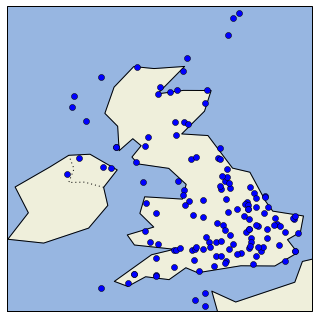

In [13]:
# Plot all station locations on a map of the UK.

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.set_extent([-10, 2, 49, 61])
plt.plot(station_lon, station_lat, 'o')
plt.show()

Here is an example of how you can search for a particular station - just change the location variable to the place you'd like to search for (in capital letters):

In [15]:
location = "SWANSEA"
print [station for station in stations if location in station]

['EGFH,SWANSEA AIRPORT,51.62158,-4.07028,91\r\n']


Now you can read in the profile data for the station you want using the station ICAO code:

In [27]:
# Get  the profile data
### All file paths here will need changing

model    = 'GlobEGRR'  # UKMO Global full domain 0.56x0.38 (Currently the only model availble)
run      = '6'         # Time in Z of the model run (Different runs may or may not be availble)
forecast = '12'        # Forecast time in hours since model run (Different forecast times may or may not be available)

# Edit the location by changing the station code below:
station  = 'EGVI'
index_of_station = stationIDs.index(station)

# Specify the date - Once the data is being updated automatically this can be changed to todays date. 
f_date   = '2016-08-31'

# Location of datafile
datafile = '%s_%s_%sZ_+%s_%s.csv' % (station, f_date, run, forecast, model)
 
# Read the data
boto.resource('s3').Bucket('tephigram').download_file(datafile, "/tmp/tephigram.csv")
with open('/tmp/tephigram.csv', 'r+b') as tephigram:
    spc_file = tephigram.read()

### Step 3: Define some constants and load some functions to help with data handling

Next I have defined some contants and loaded some functions that will be used later on when we manipulate the data. The first time you work through this notebook it will be easiest to just run them and not pay them too much attention - you can come back to them when you have a better understanding of what is coming up or when you want to make changes.

In [19]:
# Define some useful thermodynamic constants

CK = 273.15  # 0 degrees celcius in K
Cp = 1.01e3  # Specific heat capacity of air j/kgK
Lv = 2.5e6   # Latent heat of evaporation j/kgK
Rd = 287.0   # Specific gas constant of dry air j/kgK
Rv = 461.0   # Specific gas constant of moist air j/kgK

In [29]:
# Load some functions for converting between different variables. 
# All the functions below are based on functions from https://github.com/SciTools/tephi

def p_T_to_T_theta(pressure, temperature):
    # Converts pressure/temperature pairs (mbar,celcius) to temperature/potential temperature pairs (celcius,celcius)
    pressure, temperature = np.asarray(pressure), np.asarray(temperature)
    T_kelvin = temperature + CK
    theta_kelvin = T_kelvin * ((1000.0 / pressure) ** (Rd/Cp))
    theta = theta_kelvin - CK
    return temperature, theta

def p_theta_to_p_t(pressure, theta):
    # Converts pressure/potential temperature pairs (mbar,celcius) to pressure/temperature pairs (celcius,celcius)
    pressure, theta = np.asarray(pressure), np.asarray(theta)
    theta_kelvin = theta + CK
    T_kelvin = theta_kelvin * (pressure ** (Rd/Cp)) / (1000.0 ** (Rd/Cp))
    T = T_kelvin - CK
    return pressure, T

def pressure_mixing_ratio_to_temperature(pressure, mixing_ratio):
    # Converts pressure/mixing ratio pairs (mbar,ratio) to temperature (Celcius)
    pressure = np.array(pressure)
    # Calculate the dew-point.
    vapp = pressure * (8.0 / 5.0) * (mixing_ratio / 1000.0)
    T_kelvin = 1.0 / ((1.0 / CK) - ((Rv / Lv) * np.log(vapp / 6.11)))
    T = T_kelvin - CK
    return T

In [30]:
# This is a function to handle and missing data when calculating indices.

def int_mask(val):
    if val is np.ma.masked:
        return 'N/A'
    else:
        return int(val)

### Step 4: Use SHARPpy to analyse the data and do some calculations

Before SHARPpy can be used for data analysis, a SHARPpy Profile object must be created. Analysis routines can then be run on the profile object to calculate different indices. The SHARPpy basics tutorial describes this in detail and all the code in this step is taken from that tutorial: 
http://nbviewer.jupyter.org/github/sharppy/SHARPpy/blob/master/tutorials/SHARPpy_basics.ipynb

In [31]:
# Make a SHARPpy profile object

def parseSPC(spc_file):
    data = np.array([l.strip() for l in spc_file.split('\n')])
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )
    # read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt(sound_data, delimiter=',', comments="%", unpack=True)
    return p, h, T, Td, wdir, wspd

# A profile object contains:
# Pressure (pres, p, mbar), height (hght, h, m above sea level), temperature (tmpc, T, celcius), 
# dew point (dwpc, Td, celcius), wind direction (wdir, degrees), wind speed (wspd, knots)

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [32]:

# Calculate some parcel traces - see SHARPpy_basics tutorial for more info on parcel attributes
# The parcel types below are SHARPpy presets. SHARPpy also includes the functionality to make your own custom parcels (flag=5)
# - see DefineParcel in SHARPpy/sharppy/sharptab/params.py

sfcpcl = params.parcelx( prof, flag=1 )   # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 )  # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 )    # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 )    # 100 mb Mean Layer Parcel


/opt/conda/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [33]:

# Calculate some useful variables and indices 
# - see SHARPpy_basics tutorial for more information on the different variables and indices availble. 

sfc = prof.pres[prof.sfc]
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
# print "0-3 km Pressure-Weighted Mean Wind (kt):", utils.comp2vec(mean_3km[0], mean_3km[1])[1]
# print "0-6 km Shear (kt):", utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]
srwind = params.bunkers_storm_motion(prof)
# print "Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1])
# print "Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3])
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])
stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
ship = params.ship(prof)
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))     # Effective Inflow Laer Botton height (m AGL)
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))     # Effective Inflow Layer Top Height (m AGL)
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])
ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
ebwspd = utils.mag( ebwd[0], ebwd[1] )
scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)


indices = {'SBCAPE': [int_mask(sfcpcl.bplus), 'J/kg'],\
           'SBCIN': [int_mask(sfcpcl.bminus), 'J/kg'],\
           'SBLCL': [int_mask(sfcpcl.lclhght), 'm AGL'],\
           'SBLFC': [int_mask(sfcpcl.lfchght), 'm AGL'],\
           'SBEL': [int_mask(sfcpcl.elhght), 'm AGL'],\
           'SBLI': [int_mask(sfcpcl.li5), 'C'],\
           'MLCAPE': [int_mask(mlpcl.bplus), 'J/kg'],\
           'MLCIN': [int_mask(mlpcl.bminus), 'J/kg'],\
           'MLLCL': [int_mask(mlpcl.lclhght), 'm AGL'],\
           'MLLFC': [int_mask(mlpcl.lfchght), 'm AGL'],\
           'MLEL': [int_mask(mlpcl.elhght), 'm AGL'],\
           'MLLI': [int_mask(mlpcl.li5), 'C'],\
           'MUCAPE': [int_mask(mupcl.bplus), 'J/kg'],\
           'MUCIN': [int_mask(mupcl.bminus), 'J/kg'],\
           'MULCL': [int_mask(mupcl.lclhght), 'm AGL'],\
           'MULFC': [int_mask(mupcl.lfchght), 'm AGL'],\
           'MUEL': [int_mask(mupcl.elhght), 'm AGL'],\
           'MULI': [int_mask(mupcl.li5), 'C'],\
           '0-1 km SRH': [int_mask(srh1km[0]), 'm2/s2'],\
           '0-1 km Shear': [int_mask(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1]), 'kts'],\
           '0-3 km SRH': [int_mask(srh3km[0]), 'm2/s2'],\
           'Eff. SRH': [int_mask(effective_srh[0]), 'm2/s2'],\
           'EBWD': [int_mask(ebwspd), 'kts'],\
           'PWV': [round(params.precip_water(prof), 2), 'inch'],\
           'K-index': [int_mask(params.k_index(prof)), ''],\
           'STP(fix)': [round(stp_fixed, 1), ''],\
           'SHIP': [round(ship, 1), ''],\
           'SCP': [round(scp, 1), ''],\
           'STP(cin)': [round(stp_cin, 1), '']}


# The abbreiviations of the indices above are expanded below:

# SB = surface layer parcel (CAPE, CIN, LCL, LFC, EL, lI)
# ML = 100mb mean layer parcel (CAPE, CIN, LCL, LFC, EL, lI)
# MU = Most unstable parcel (CAPE, CIN, LCL, LFC, EL, lI)
# 0-1km SRH = 0-1km Storm relative helicity
# 0-1km shear
# 0-3km SRH = 0-3km storm relative helicity
# EFF. SRH = Effective Inflow Layer storm relative helicity
# EBWD = Effective Bulk Wind Difference
# PWV = Precipitable water
# K-index
# STP(fix) = Significant Tornado Parameter (fixed)
# SHIP = Significant Hail Parameter
# SCP = Supercell composite parameter
# STP(CIN) = Significant Tornado Parameter (w/CIN)

# To print out the indices:

for key in np.sort(indices.keys()):
    string = key + ': ' + str(indices[key][0]) + ' ' + indices[key][1]
    print string


/opt/conda/envs/py2/lib/python2.7/site-packages/sharppy/sharptab/interp.py:53: RuntimeWarning: divide by zero encountered in log10
  return generic_interp_pres(np.log10(p), prof.logp[::-1], prof.hght[::-1])


0-1 km SRH: 7 m2/s2
0-1 km Shear: 2 kts
0-3 km SRH: 16 m2/s2
EBWD: N/A kts
Eff. SRH: 0 m2/s2
K-index: -17 
MLCAPE: 0 J/kg
MLCIN: 0 J/kg
MLEL: 1475 m AGL
MLLCL: 1475 m AGL
MLLFC: N/A m AGL
MLLI: 10 C
MUCAPE: 0 J/kg
MUCIN: 0 J/kg
MUEL: 1065 m AGL
MULCL: 1065 m AGL
MULFC: N/A m AGL
MULI: 8 C
PWV: 0.49 inch
SBCAPE: 0 J/kg
SBCIN: 0 J/kg
SBEL: 1065 m AGL
SBLCL: 1065 m AGL
SBLFC: N/A m AGL
SBLI: 8 C
SCP: nan 
SHIP: 0.0 
STP(cin): nan 
STP(fix): 0.0 


/opt/conda/envs/py2/lib/python2.7/site-packages/sharppy/sharptab/interp.py:186: RuntimeWarning: divide by zero encountered in log10
  U = generic_interp_pres(np.log10(p), prof.logp[::-1], prof.u[::-1])
/opt/conda/envs/py2/lib/python2.7/site-packages/sharppy/sharptab/interp.py:187: RuntimeWarning: divide by zero encountered in log10
  V = generic_interp_pres(np.log10(p), prof.logp[::-1], prof.v[::-1])


### Step 5: Plot the data on a tephigram

Below is an example of how you might use the data from the SHARPpy profile object to plot a tephigram. 

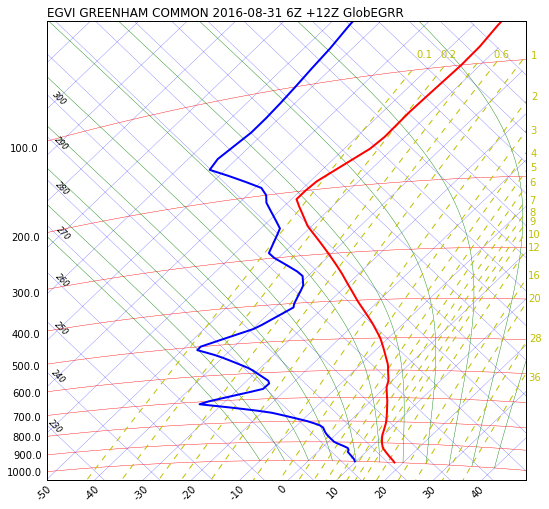

In [60]:

# To plot the tephigram we plot a base grid of temperature versus entropy (Cp*ln(theta)). 
# This grid is rotated by 45 degrees and all other lines are plotted by calculating corresponding temperature/entropy pairs.

# The function below is used to calculate entropy from potential temperature values:

def ent(thetas, invert=False):
    if invert==False:
        return Cp*np.log(thetas)
    else:
        return np.exp(thetas/Cp)

# This function builds the plot

def Tephigram(prof, title):
    # First make some seperate arrays containing different variables to plot: 
    prof_temp = prof.tmpc                                # Temperature (C)
    prof_pres = prof.pres                                # Pressure (mbar)
    prof_dw = prof.dwpc                                  # Dew point (C)
    _,prof_theta_T = p_T_to_T_theta(prof_pres,prof_temp) # Potential temperature (C)
    _,prof_theta_dw = p_T_to_T_theta(prof_pres,prof_dw)  # Wet bulb potential temperature (C)

    # Clean up & build the figure
    
    fig = plt.figure(figsize=(8.5875, 8.2125))  # Change the figure size here
    ax  = fig.add_subplot(111)

    # Rotate the coordinate system -45 degrees & hide the rotated axis:

    Axes._set_lim_and_transforms(ax)
    ax.transDataToAxes = ax.transScale + (ax.transLimits + transforms.Affine2D().rotate_deg(-45))
    ax.transData = ax.transDataToAxes + ax.transAxes
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Set axis limits
    # WARNING: This plot is not designed to have flexible axis at the moment due to difficulties in axis labelling and 
    #          me running out of time to come up with a better solution. The axis set below should be fine for UK weather.

    plt.ylim(ent(220), ent(370))
    plt.xlim(-50, 90)

    # List where we want to label all the lines

    T_ticks      = np.arange(-200,60,10)
    theta_ticks  = ent(np.arange(200,450,10))
    P_ticks      = np.arange(100.,1100.,100)
    sat_adiabats = [-20,-15,-10,-5,0,5,10,15,20,25,30,35]
    mixing_ratios= [0.1,0.2,0.4,0.6,1,2,3,4,5,6,7,8,9,10,12,16,20,28,36]

    # Plot constant T lines

    for t in T_ticks:
        plot_Ts = np.full(len(theta_ticks), t, dtype=np.int64)
        plt.plot(plot_Ts, theta_ticks, linestyle='-', color='b', lw=0.2) # Change linestyle/thickness/color here
    
    # Label the T lines - this is currently axis specific, and not a good way to plot lines labels.

    t_text_labels = [-50, -40, -30,-20, -10, 0, 10, 20, 30, 40]
    theta_label = ent(216)
    for t in t_text_labels:
        ax.text(t,theta_label,str(t), rotation=45)
        theta_label=theta_label+37.5

    # Plot constant theta lines

    for theta in theta_ticks:
        plot_thetas = np.full(len(T_ticks), theta, dtype=np.int64)
        plt.plot(T_ticks, plot_thetas, color='b', linestyle='-', lw=0.2) # Change linestyle/thickness/color here
    
    # Label the theta lines - this is currently axis specific axis specific, and not a good way to plot lines labels.
    
    theta_text_labels = [300, 290, 280, 270, 260, 250, 240, 230]
    t_label = -132
    for theta in theta_text_labels:
        ax.text(t_label,ent(theta),str(theta),  fontstyle='italic', fontsize=8, rotation=-45)
        t_label=t_label+10

    # Plot & label constant pressure lines

    T_plot = np.linspace(-200,50,200) # long list of T values to plot
    p_line_label_t_vals = [-128.5,-109,-97,-88,-81,-75,-70,-65.5,-61.5,-59]
    theta = np.empty([len(P_ticks), len(T_plot)])
    for i in range(0, len(P_ticks)):
        theta[i,:]=(T_plot+CK)*(1000/P_ticks[i])**(Rd/Cp)
        plt.plot(T_plot, ent(theta[i]), color='r', lw=0.4) # Change linestyle/thickness/color here
        new_theta_label= (p_line_label_t_vals[i]+CK)*(1000/P_ticks[i])**(Rd/Cp)
        plt.text(p_line_label_t_vals[i],ent(new_theta_label), str(P_ticks[i]))

    # Plot  & label saturation adiabats
    # Using SHARPpys 'wetlift' routine which uses the Wobus function to calculate saturation adiabats.

    pmax = 1000
    pmin = 10
    dp = -10
    presvals = np.arange(int(pmax), int(pmin)+dp, dp)

    for t in np.arange(-10,45,5):
        tw = np.array([])
        i=0
        for p in presvals:
            tw = np.append(tw, thermo.wetlift(1000., t, p))
        _,thetas_sat = p_T_to_T_theta(presvals,tw)
        thetas_sat = np.asarray(thetas_sat)
        thetas_sat_K = thetas_sat + CK
        plt.plot(tw,ent(thetas_sat_K), color='g', lw=0.4) # Change linestyle/thickness/color here
        # I've chosen just to label the adiabats where they cross the 100mbar pressure line. 
    if t>0 and t<40:
            ax.text(tw[90]-2, ent(thetas_sat_K[90]),str(t), color='g')

    # Plot & label mixing ratio lines

    # More terrible axis specific line labelling, -999 means skip this label so labels don't overlap. 
    mix_text_T=[    -65,  -60,-999, -49,-41,-32,-25,-20,    -17,  -14,  -10,-7.5,-5.5,   -3,    0,  6,   11, 20, 28]
    mix_text_theta=[410,417.5,-999, 435,447,433,421,413.5,408.5,403.5,397.5, 394, 391,386.5,382.5,374,367.5,356,345]

    mr_P = np.linspace(100,1200,200)
    for i in range(0,len(mixing_ratios)):
        temps_mix = pressure_mixing_ratio_to_temperature(mr_P, mixing_ratios[i])
        _,thetas_mix = p_T_to_T_theta(mr_P,temps_mix)
        thetas_mix_K = thetas_mix + CK
        plt.plot(temps_mix,ent(thetas_mix_K), color='y', linestyle='--') # Change linestyle/thickness/color here
        if mix_text_T[i]!=-999:
            ax.text(mix_text_T[i],ent(mix_text_theta[i]), str(mixing_ratios[i]), color='y')      

    # Plot the profile

    plt.plot(prof_temp, ent(prof_theta_T + CK), color='r', lw=2) # Change linestyle/thickness/color here
    plt.plot(prof_dw, ent(prof_theta_dw + CK), color='b', lw=2)  # Change linestyle/thickness/color here
    
    plt.title(title, fontsize=12, loc='left')
    
    return ax


# Make the plot title

title = station + ' ' + station_name[index_of_station] +' ' +  f_date + ' '+ run+'Z'+' '+ '+' + forecast + 'Z' + ' ' + model

# Call the function to show the plot

_ = Tephigram(prof, title)

Now we can add some more info to the plot - parcel traces, wind barbs, a hodograph and the list of indices we calculated earlier:

In [61]:

# This function adds wind barbs to the right hand side of the plot

def plot_barbs(ax, prof):

# First we get rid of all the points where there's no data, put these in new_u / new_v
    masked_indices=[]
    barb_pressures=[]
    new_u=[]
    new_v=[]
    u_mask= np.ma.getmask(prof.u)
    v_mask= np.ma.getmask(prof.v)
    for i in range(0, len(u_mask)):
        if u_mask[i] == False and v_mask[i]==False:
            masked_indices.append(i)
            barb_pressures.append(prof.pres[i])
            new_u.append(prof.u[i])
            new_v.append(prof.v[i])

# Get rid of any data higher than 100mb and count how many barbs are left.
    barb_pressures=np.asarray(barb_pressures)
    barb_pressures = barb_pressures[barb_pressures>100.]
    num_barbs_total = len(barb_pressures)
    new_u=new_u[0:num_barbs_total]
    new_v=new_v[0:num_barbs_total]

# We want around 15 barbs ish, so if there are more, filter out a few
    if num_barbs_total>20 and num_barbs_total<30:
            new_u = new_u[0:num_barbs_total:2]
            new_v = new_v[0:num_barbs_total:2]
            barb_pressures = barb_pressures[0:num_barbs_total:2]
    elif num_barbs_total>30 and num_barbs_total<50:
            new_u = new_u[0:num_barbs_total:3]
            new_v = new_v[0:num_barbs_total:3]    
            barb_pressures = barb_pressures[0:num_barbs_total:3]
    else:
            new_u = new_u[0:num_barbs_total:5]
            new_v = new_v[0:num_barbs_total:5]
            barb_pressures = barb_pressures[0:num_barbs_total:5]

# Count how many barbs we have now.
    num_barbs = len(new_u)

# Start by getting the data coords of the barbs along the -50 T line
    barb_t = -50*np.ones(num_barbs)
    _,barb_theta = p_T_to_T_theta(barb_pressures,barb_t)
    barb_theta_K=barb_theta+CK

# Now transform data coords to axes coords and plot each barb at 0.95 on the x axis
    inv = ax.transAxes.inverted()

    for i in range(0, num_barbs):
        disp_point = ax.transData.transform((barb_t[i], ent(barb_theta_K[i])))
        axes_point = inv.transform(disp_point)
        plt.barbs(0.95,axes_point[1],new_u[i], new_v[i], transform=ax.transAxes)
        
    return


# This function plots a parcel trace. Choose a parcel type: 
# Surface parcel = sfcpcl, forecast parcel = fcstpcl, most-unstable parcel = mupcl, Mean mixed layer parcel = mlpcl

def plot_parcel_trace(ax,parcel_type):
# Set the parcel trace to be plotted
    pcl = parcel_type    #sfcpcl, fcstpcl, mupcl, mlpcl
    _,prof_theta_trace = p_T_to_T_theta(pcl.ptrace,pcl.ttrace)
    plt.plot(pcl.ttrace, ent(prof_theta_trace + CK), 'k-.', lw=2) # plot the parcel trace 
    return


# Plot a hodograph

def plot_hodograph(ax,prof):
    below_12km = np.where(interp.to_agl(prof, prof.hght) < 12000)[0]
    u_prof = prof.u[below_12km]
    v_prof = prof.v[below_12km]
    ax.plot(u_prof[~u_prof.mask], v_prof[~u_prof.mask], 'k-', lw=2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for i in range(10,90,10):
    # Draw the range rings around the hodograph.
        circle = plt.Circle((0,0),i,color='k',alpha=.3, fill=False)
        ax.add_artist(circle)
        ax.plot(srwind[0], srwind[1], 'ro') # Plot Bunker's Storm motion right mover as a red dot
        ax.plot(srwind[2], srwind[3], 'bo') # Plot Bunker's Storm motion left mover as a blue dot

    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    return


# Plot the indices we calculated earlier alongside the tephigram

def plot_indices(ax,indices):
# List the indices within the indices dictionary on the side of the plot.
    string = ''
    for key in np.sort(indices.keys()):
        string = string + key + ': ' + str(indices[key][0]) + ' ' + indices[key][1] + '\n'
    plt.text(1.07, 0.72, string, verticalalignment='top', transform=plt.gca().transAxes)
    return

Putting it all together we get: 

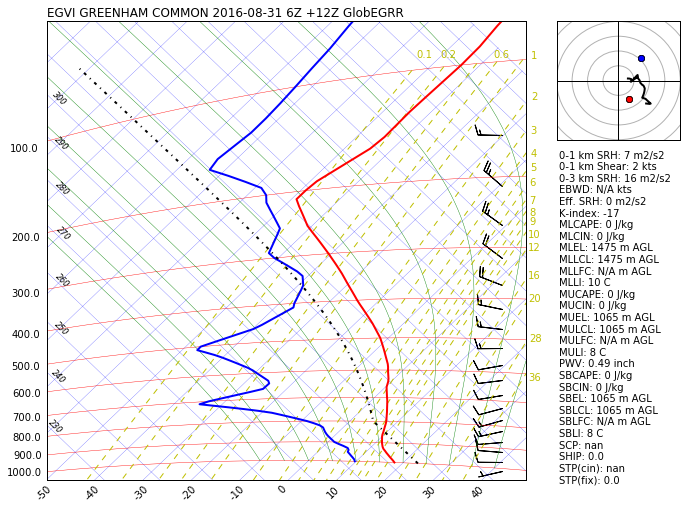

In [62]:
ax = Tephigram(prof, title)       # Plot the tephigram
plot_parcel_trace(ax, fcstpcl)    # Plot parcel trace: sfcpcl, fcstpcl, mupcl or mlpcl
plot_indices(ax, indices)         # Plot storm indices
plot_barbs(ax, prof)              # Plot wind barbs
ax2 = plt.axes([0.95,0.7,.2,.2])  # Position hodograph
plot_hodograph(ax2, prof)         # Plot hodograph

Don't forget to have a look at the dashboard view. Have fun experimenting with SHARPpy and building your own notebooks!